### 6.1 합성곱층을 통한 학습

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
import tqdm as tqdm

In [2]:
import os
root_dir = "/content/drive/MyDrive/2022 DataCreatorCamp_나 is NICE/대학부 데이터셋/"
image_label = os.listdir(root_dir)
image_label.remove(".DS_Store")
image_label = image_label[:5]
image_label

['L2_39', 'L2_12', 'L2_41', 'L2_52', 'L2_30']

In [3]:
# opencv를 통해 이미지 로드하고 이미지의 사이즈가 모두 동일하게 변경
train_x = []
train_y = []
test_x = []
test_y = []
dataset = []

def create_dataset(directory, dir_name):
  for i in tqdm.tqdm(os.listdir(directory)):
    full_path = os.path.join(directory, i)
    try:
      img = cv2.imread(full_path) #이미지 읽기
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #RGB형태로 변환
      img = cv2.resize(img, (150,150)) #이미지 사이즈 변경
    except:
      continue

    if dir_name == "alien_test":
      test_x.append(img)
      test_y.append(i)
    else:
      train_x.append(img)
      train_y.append(dir_name)
  return train_x, train_y, test_x, test_y

In [4]:
for img_label in image_label:
  trian_x, train_y, test_x, test_y = create_dataset(f"{root_dir}{img_label}", img_label)

100%|██████████| 364/364 [00:12<00:00, 29.99it/s]


In [5]:
#배열 형태로 x, y 값 변경
x = np.array(train_x)
y = np.array(train_y)
x.shape, y.shape

((2311, 150, 150, 3), (2311,))

In [6]:
#학습세트와 검증세트를 분리
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=42)

In [7]:
img_size =150 #이미지 150픽셀로 만들어줌

x_train = np.array(x_train)/255.0 #학습에 사용하기 적합한 형태로 만들어줌
x_valid = np.array(x_valid)/255.0

x_train = x_train.reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

x_valid = x_valid.reshape(-1, img_size, img_size, 3)
y_valid = np.array(y_valid)


In [8]:
#예측에 사용할 데이터 세트의 사이즈 변경
x_test = np.array(test_x).reshape(-1, img_size, img_size, 3)
x_test.shape

(0, 150, 150, 3)

In [9]:
#LabelBinaizer을 통해 정답값을 one-hot 형태로 변경
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_train_lb = lb.fit_transform(y_train)
y_valid_lb = lb.fit_transform(y_valid)
y_train_lb.shape, y_valid_lb.shape

((1848, 5), (463, 5))

In [10]:
# one-hot형태로 변경된 정답값
y_train_lb

array([[0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       ...,
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0]])

In [11]:
# 변경된 값을 비교해보기 위해 정답값을 딕셔너리 형태로 만들어놓음
label_name = dict(zip(np.argmax(y_train_lb, axis=1),y_train))
label_name

{1: 'L2_30', 3: 'L2_41', 2: 'L2_39', 0: 'L2_12', 4: 'L2_52'}

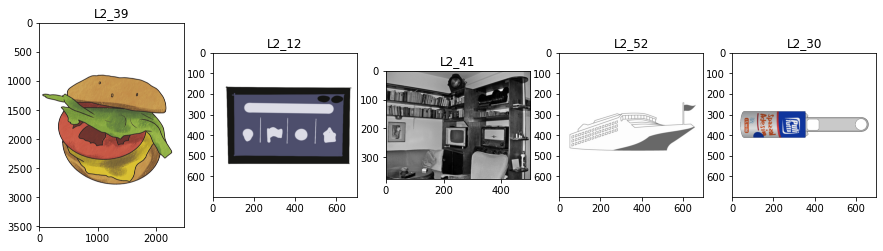

In [12]:
#학습에 사용할 이미지 확인

fig, ax = plt.subplots(1, 5, figsize=(15,10))

for i, folder in enumerate(image_label):
  sample_paper = np.random.choice(os.listdir(root_dir + folder))
  image = plt.imread(f"{root_dir}{folder}/{sample_paper}")
  ax[i].imshow(image)
  ax[i].set_title(folder)


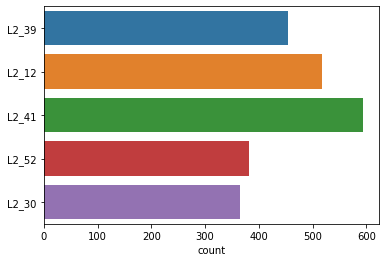

In [13]:
# 예측값의 종류별 빈도수 확인
sns.countplot(y=y)

In [14]:
# 합성곱신경망 구현

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(filters=32, kernel_size=(4,4), strides=1, padding='valid',))
model.add(MaxPooling2D(2,2))
print(model.output_shape)
model.add(Flatten())
print(model.output_shape)
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

(None, 36, 36, 32)
(None, 41472)


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        16416     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 256)               1

In [16]:
# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [17]:
# 학습하면서 성능 나아지지 않으면 학습을 일찍 멈추도록 EarlyStopping 설정
from tensorflow.keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)

# 모델 학습
history = model.fit(x_train, y_train_lb, epochs=30, validation_data=(x_valid, y_valid_lb), batch_size=32, verbose=1, callbacks=earlystop)

Epoch 1/30
58/58 [==============================] - 6s 33ms/step - loss: 3.3991 - accuracy: 0.4232 - val_loss: 0.9574 - val_accuracy: 0.6069
Epoch 2/30
58/58 [==============================] - 1s 23ms/step - loss: 0.8819 - accuracy: 0.6255 - val_loss: 0.9592 - val_accuracy: 0.5572
Epoch 3/30
58/58 [==============================] - 1s 23ms/step - loss: 0.7252 - accuracy: 0.7186 - val_loss: 0.9660 - val_accuracy: 0.6285
Epoch 4/30
58/58 [==============================] - 1s 23ms/step - loss: 0.5544 - accuracy: 0.7906 - val_loss: 0.7841 - val_accuracy: 0.6263
Epoch 5/30
58/58 [==============================] - 1s 23ms/step - loss: 0.4098 - accuracy: 0.8588 - val_loss: 0.8722 - val_accuracy: 0.6631
Epoch 6/30
58/58 [==============================] - 1s 23ms/step - loss: 0.2867 - accuracy: 0.9172 - val_loss: 0.8740 - val_accuracy: 0.6479
Epoch 7/30
58/58 [==============================] - 1s 23ms/step - loss: 0.1849 - accuracy: 0.9513 - val_loss: 0.8743 - val_accuracy: 0.6523
Epoch 8/30
58

In [18]:
# 학습 결과를 데이터프레임 형태로 변환
df_hist = pd.DataFrame(history.history)
df_hist.head()

,loss,accuracy,val_loss,val_accuracy
0,3.399141,0.423160,0.957426,0.606911
1,0.881918,0.625541,0.959228,0.557235
2,0.725193,0.718615,0.965950,0.628510
3,0.554411,0.790584,0.784138,0.626350
4,0.409839,0.858766,0.872240,0.663067


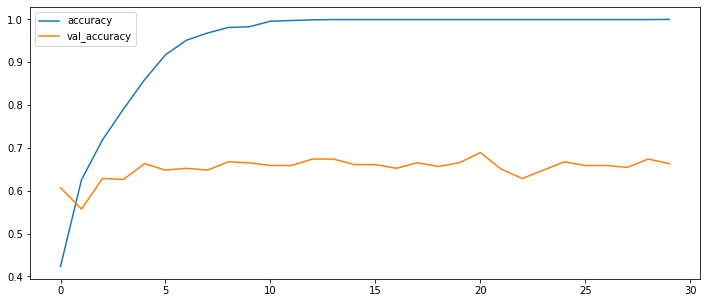

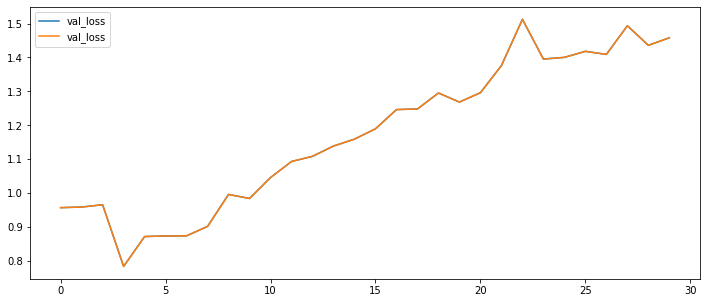

In [19]:
# 학습 결과 시각화
df_hist[['accuracy', 'val_accuracy']].plot(figsize=(12,5))
df_hist[['val_loss', 'val_loss']].plot(figsize=(12,5))

In [20]:
# 예측값의 크기 확인
x_test.shape

(0, 150, 150, 3)

In [ ]:
# 예측 시작
predict = model.predict(x_test)
y_predict = np.argmax(predict, axis=1)
y_predict

In [ ]:
# 정답지 불러옴
df_test = pd.read_csv(f"{root_dir}/test.csv") #여기에 경로 넣기
df_test = df_test.set_index("Image_id").loc[test_y].reset_index()
df_test.head()

In [ ]:
# 정확도 직접 구하기
(y_test == y_predict).mean()

In [ ]:
# 정답지 시각화
plt.figure(figsize=(12,15))
for index, row in df_test.iterrows():
  filename = row['Image_id']
  category = row['labels']
  img = x_test[index]
  plt.subplot(6,5,index+1)
  plt.imshow(img)
  if category != y_predict[index]:
    c="red"
  else:
    c="black"
  plt.xlabel(f"{filename}(label_name[y_predict[index]]}", color = c)
plt.tight_layout()
plt.show()

### 6.2 데이터 증강

In [21]:
# keras의 전처리층 사용하여 데이터 증강
# 이미지를 변형하기 때문에 정보가 왜곡 될 수 있음

from tensorflow.keras.layers.experimental import preprocessing
img_size = 150

data_augmentation = Sequential([
    preprocessing.Resizing(img_size, img_size), #사이즈 변경
    preprocessing.RandomFlip("horizontal_and_vertical"), #뒤집기
    preprocessing.RandomContrast(1), #대비 변경
    preprocessing.RandomRotation(0.2), #회전
    preprocessing.RandomZoom(0.2), #확대, 축소
])


In [23]:
# 모델 상단에 위에서 만든 data_augmentation 추가

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

model = Sequential()
model.add(data_augmentation)
model.add(Conv2D(filters=32, kernel_size = (3,3), strides=1, padding = 'same', input_shape=(150,150,3)))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [27]:
# 모델 학습
from tensorflow.keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)

history=model.fit(x_train, y_train_lb, epochs=30, validation_data=(x_valid, y_valid_lb), batch_size=32, verbose=1, callbacks=earlystop)

Epoch 1/30
58/58 [==============================] - 17s 291ms/step - loss: 1.0014 - accuracy: 0.5292 - val_loss: 0.9817 - val_accuracy: 0.5400
Epoch 2/30
58/58 [==============================] - 10s 167ms/step - loss: 0.9761 - accuracy: 0.5498 - val_loss: 0.9673 - val_accuracy: 0.5616
Epoch 3/30
58/58 [==============================] - 9s 148ms/step - loss: 0.9953 - accuracy: 0.5292 - val_loss: 0.9561 - val_accuracy: 0.5724
Epoch 4/30
58/58 [==============================] - 8s 146ms/step - loss: 0.9792 - accuracy: 0.5465 - val_loss: 1.0307 - val_accuracy: 0.5335
Epoch 5/30
58/58 [==============================] - 9s 149ms/step - loss: 0.9690 - accuracy: 0.5357 - val_loss: 0.9936 - val_accuracy: 0.5205
Epoch 6/30
58/58 [==============================] - 8s 146ms/step - loss: 0.9707 - accuracy: 0.5384 - val_loss: 0.9851 - val_accuracy: 0.5140
Epoch 7/30
58/58 [==============================] - 9s 148ms/step - loss: 1.0021 - accuracy: 0.5206 - val_loss: 0.9568 - val_accuracy: 0.5335
Epoc

In [31]:
df_hist = pd.DataFrame(history.history)
df_hist.head()

,loss,accuracy,val_loss,val_accuracy
0,1.001423,0.529221,0.981731,0.539957
1,0.976114,0.549784,0.967292,0.561555
2,0.995269,0.529221,0.956062,0.572354
3,0.979191,0.546537,1.030694,0.533477
4,0.969046,0.535714,0.993604,0.520518


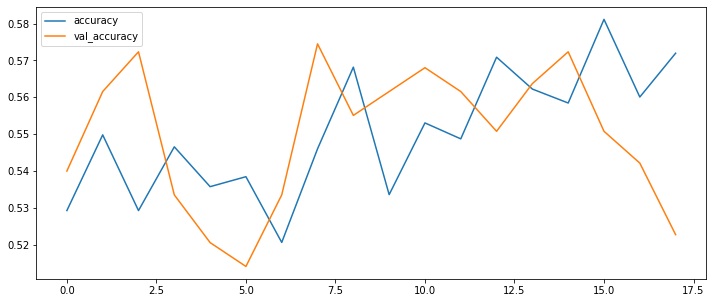

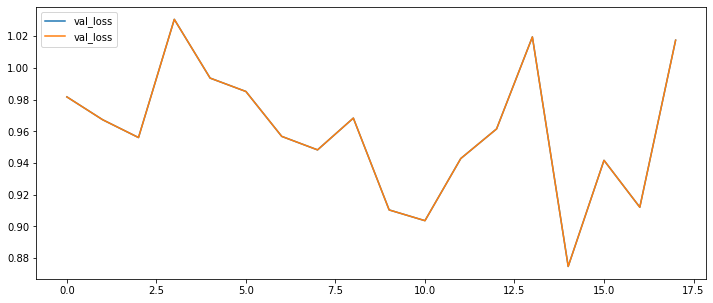

In [33]:
df_hist[['accuracy', 'val_accuracy']].plot(figsize=(12,5))
df_hist[['val_loss', 'val_loss']].plot(figsize=(12,5))

### 6.3 배치 정규화

In [34]:
# 배치정규화 tensorflow에 내장된 함수 사용

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same', input_shape=(150,150,3)))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(4,4), strides=1, padding='valid', ))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [38]:
from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)

history = model.fit(x_train, y_train_lb, epochs=30, validation_data=(x_valid, y_valid_lb), batch_size=32, verbose=1, callbacks=earlystop)

Epoch 1/30
58/58 [==============================] - 2s 35ms/step - loss: 5.1629e-04 - accuracy: 1.0000 - val_loss: 1.5225 - val_accuracy: 0.6523
Epoch 2/30
58/58 [==============================] - 2s 28ms/step - loss: 4.9009e-04 - accuracy: 1.0000 - val_loss: 1.5336 - val_accuracy: 0.6587
Epoch 3/30
58/58 [==============================] - 1s 24ms/step - loss: 4.6818e-04 - accuracy: 1.0000 - val_loss: 1.5586 - val_accuracy: 0.6587
Epoch 4/30
58/58 [==============================] - 1s 25ms/step - loss: 4.5319e-04 - accuracy: 1.0000 - val_loss: 1.5238 - val_accuracy: 0.6652
Epoch 5/30
58/58 [==============================] - 1s 25ms/step - loss: 4.4390e-04 - accuracy: 1.0000 - val_loss: 1.5348 - val_accuracy: 0.6631
Epoch 6/30
58/58 [==============================] - 1s 25ms/step - loss: 3.4491e-04 - accuracy: 1.0000 - val_loss: 1.5683 - val_accuracy: 0.6631
Epoch 7/30
58/58 [==============================] - 1s 25ms/step - loss: 3.7167e-04 - accuracy: 1.0000 - val_loss: 1.5923 - val_ac

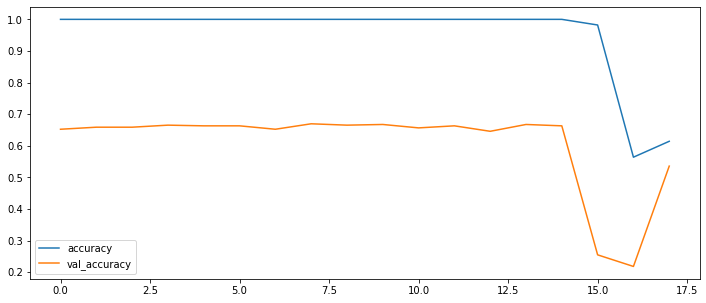

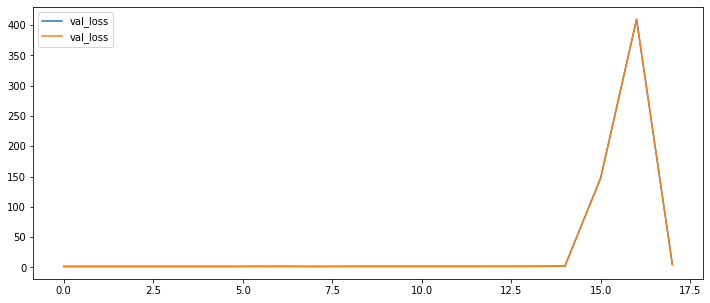

In [39]:
df_hist = pd.DataFrame(history.history)
df_hist[['accuracy', 'val_accuracy']].plot(figsize=(12,5))
df_hist[['val_loss', 'val_loss']].plot(figsize=(12,5))